# 前提

## インポート

In [75]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from keras.utils import np_utils 
import tqdm
from sklearn.utils import check_array, check_random_state
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

In [863]:
pd.set_option('display.max_rows',10)
pd.set_option('display.max_columns', 10)

## モデル

### 普通のLFA

In [80]:
class MatrixFactorization():
    def __init__(self, R, alpha, lamda,k=60, steps=200,threshold=0.001):
        self.R = R
        self.m = R.shape[0]#Rの列数
        self.n = R.shape[1]#Rの行数
        self.X=np.arange(0,self.m)
        self.Y=np.arange(0,self.n)
        self.k = k #潜在因子分析の次元
        # initializa U and V
        self.U = np.random.rand(self.m, self.k)#0.0から1の範囲でm×k行列の乱数を発生させる
        self.V = np.random.rand(self.k, self.n)#0.0から1の範囲でk×n行列の乱数を発生させる
        self.alpha = alpha #学習率
        self.lamda = lamda #正則化項の係数
        self.threshold = threshold #誤差の閾値
        self.steps = steps #シャッフルする回数
        
    def shuffle_in_unison_scary(self, a, b):
        rng_state = np.random.get_state()
        np.random.shuffle(a)
        np.random.set_state(rng_state)
        np.random.shuffle(b)

    def fit(self):
        for step in tqdm.tqdm(range(self.steps)):
            error = 0
            self.shuffle_in_unison_scary(self.X,self.Y)
            for i in self.X:
                for j in self.Y:
                    r_ij = self.R[i,j] #r_ij=R[i,j]とする
                    if r_ij != 0: #Rの要素が0以外の値をとる場合更新する
                        err_ij = r_ij - np.dot(self.U[i,:], self.V[:,j]) #誤差err_ijはr_ijからUのi-1行目とVのj-1列目をかけあわせたものを引いた値
                        for q in range(self.k):#潜在因子分析の次元数であるk回以下を繰り返す
                            delta_u = self.alpha * (err_ij * self.V[q, j] - self.lamda * self.U[i, q])
                            delta_v = self.alpha * (err_ij * self.U[i, q] - self.lamda * self.V[q, j])
                            self.U[i, q] += delta_u
                            self.V[q, j] += delta_v
                            

            R_hat = np.dot(self.U, self.V) #UとVを掛け合わせたものがR_hatになる
            for i in self.X:
                for j in self.Y:
                    r_ij = self.R[i, j]
                    r_hat_ij = R_hat[i, j]
                    if r_ij != 0:
                        error += pow(r_ij - r_hat_ij,2)/2
            error += (self.lamda * np.power(self.U,2).sum()) / 2
            error += (self.lamda * np.power(self.V,2).sum()) / 2

            if error < self.threshold:
                break
        return self.U, self.V

### 提案手法１(重みを変えない)

#### どちらにもクラスター

In [761]:
class MatrixFactorization_1():
    def __init__(self,R,C,D,U,V,k,steps=200, alpha=0.001,beta=1.0,ganma=1.0,lamda=0.01,threshold=0.001):
        self.R = R
        self.C = C
        self.D = D
        
        self.m = R.shape[0]#Rの行数
        self.n = R.shape[1]#Rの列数
        self.l = C.shape[1]#Cの列数
        self.o = D.shape[0]#Dの行数
        
        self.X=np.arange(0,self.m)
        self.Y=np.arange(0,self.n)
        self.Z=np.arange(0,self.l)
        self.A=np.arange(0,self.o)
        self.k = k #潜在因子分析の次元
        
        self.U = U
        self.V = V #転置した状態のものを入れる
        self.S = np.random.rand(self.k, self.l)#0.0から1の範囲でk×l行列の乱数を発生させる
        self.T = np.random.rand(self.o, self.k)#0.0から1の範囲でo×k行列の乱数を発生
        
        self.alpha = alpha #学習率
        self.beta = beta #CとPSの誤差の係数
        self.ganma = ganma #DとTVの誤差の係数
        self.lamda = lamda #正則化項の係数
        self.threshold = threshold #誤差の閾値
        self.steps = steps #シャッフルする回数
        
    def shuffle_in_unison_scary(self, a, b):
        rng_state = np.random.get_state()
        np.random.shuffle(a)
        np.random.set_state(rng_state)
        np.random.shuffle(b)
        np.random.set_state(rng_state)
        np.random.shuffle(c)
        np.random.set_state(rng_state)
        np.random.shuffle(d)

    def fit(self):
        for step in tqdm.tqdm(range(self.steps)):
            error = 0
            self.shuffle_in_unison_scary(self.X,self.Y,self.Z,self.A)
            for i in self.X:
                #beta_i=round(self.beta*(1/self.user_clust_std[self.label_U[i]]),3)
                for j in self.Y:
                    #ganma_j=round(self.ganma*(1/self.service_clust_std[self.label_V[j]]),3)
                    r_ij = self.R[i,j] #r_ij=R[i,j]とする
                    for l in self.Z:
                        c_il = self.C[i,l] #c_il=C[i,l]とする
                        err_c_il=c_il-np.dot(self.U[i,:],self.S[:,l])#cの誤差
                        for k in self.A:
                            d_kj = self.D[k,j]
                            err_d_kj = d_kj-np.dot(self.T[k,:],self.V[:,j])
                            if r_ij != 0: #Rの要素が0以外の値をとる場合更新する
                                err_r_ij = r_ij - np.dot(self.U[i,:], self.V[:,j]) #誤差err_r_ijはr_ijからUのi行目とVのj列目をかけあわせたものを引いた値
                                for q in range(self.k):#潜在因子分析の次元数であるk回以下を繰り返す
                                    delta_u = self.alpha * (err_r_ij * self.V[q, j] + self.beta * err_c_il * self.S[q,l]- self.lamda * self.U[i, q])
                                    delta_v = self.alpha * (err_r_ij * self.U[i, q] +self.ganma * err_d_kj * self.T[k,q]- self.lamda * self.V[q, j])
                                    delta_s = self.alpha * (self.beta * err_c_il * self.U[i, q] - self.lamda * self.S[q,l])
                                    delta_t = self.alpha * (self.ganma * err_d_kj * self.V[q,j] - self.lamda * self.T[k,q])
                                    self.U[i, q] += delta_u
                                    self.V[q, j] += delta_v
                                    self.S[q, l] += delta_s
                                    self.T[k, q] += delta_t

            R_hat = np.dot(self.U, self.V) #UとVを掛け合わせたものがR_hatになる
            C_hat = np.dot(self.U, self.S)
            D_hat = np.dot(self.T, self.V)
            for i in self.X:
                for j in self.Y:
                    r_ij = self.R[i, j]
                    r_hat_ij = R_hat[i, j]
                    if r_ij != 0:
                        error += pow(r_ij - r_hat_ij,2)/2
            for i in self.X:
                #beta_i=round(self.beta*(1/self.user_clust_std[self.label_U[i]]),3)
                for l in self.Z:
                    c_il = self.C[i,l]
                    c_hat_il = C_hat[i,l]
                    error += self.beta*pow(c_il-c_hat_il,2)/2
            for j in self.Y:
                #ganma_j=round(self.ganma*(1/self.service_clust_std[self.label_V[j]]),3)
                for k in self.A:
                    d_kj = self.D[k,j]
                    d_hat_kj = D_hat[k,j]
                    error += self.ganma*pow(d_kj-d_hat_kj,2)/2
                    
            error += (self.lamda * np.power(self.U,2).sum()) / 2
            error += (self.lamda * np.power(self.V,2).sum()) / 2
            error += (self.lamda * np.power(self.S,2).sum()) / 2
            error += (self.lamda * np.power(self.T,2).sum()) / 2

            if error < self.threshold:
                break
        return self.U, self.V,self.S,self.T

#### ユーザーのみにクラスター構造

In [692]:
class MatrixFactorization_1_1():
    def __init__(self,R,C,U,V,k,steps=200, alpha=0.01,beta=0.1,lamda=0.01,threshold=0.001):
        self.R = R
        self.C = C
        
        self.m = R.shape[0]#Rの行数
        self.n = R.shape[1]#Rの列数
        self.l = C.shape[1]#Cの列数
        
        self.X=np.arange(0,self.m)
        self.Y=np.arange(0,self.n)
        self.Z=np.arange(0,self.l)

        self.k = k #潜在因子分析の次元
        
        
        self.U = U
        self.V = V #転置した状態で入れる
        self.S = np.random.rand(self.k, self.l)#0.0から1の範囲でk×l行列の乱数を発生させる
        
        self.alpha = alpha #学習率
        self.beta = beta #CとPSの誤差の係数
        self.lamda = lamda #正則化項の係数
        self.threshold = threshold #誤差の閾値
        self.steps = steps #シャッフルする回数
        
    def shuffle_in_unison_scary(self, a, b):
        rng_state = np.random.get_state()
        np.random.shuffle(a)
        np.random.set_state(rng_state)
        np.random.shuffle(b)
        np.random.set_state(rng_state)
        np.random.shuffle(c)

    def fit(self):
        for step in range(self.steps):
            error = 0
            self.shuffle_in_unison_scary(self.X,self.Y,self.Z)
            for i in self.X:
                
                for j in self.Y:
                    
                    r_ij = self.R[i,j] #r_ij=R[i,j]とする
                    for l in self.Z:
                        c_il = self.C[i,l] #c_il=C[i,l]とする
                        err_c_il=c_il-np.dot(self.U[i,:],self.S[:,l])#cの誤差
                        
                        if r_ij != 0: #Rの要素が0以外の値をとる場合更新する
                            err_r_ij = r_ij - np.dot(self.U[i,:], self.V[:,j]) #誤差err_r_ijはr_ijからUのi行目とVのj列目をかけあわせたものを引いた値
                            for q in range(self.k):#潜在因子分析の次元数であるk回以下を繰り返す
                                delta_u = self.alpha * (err_r_ij * self.V[q, j] + self.beta * err_c_il * self.S[q,l]- self.lamda * self.U[i, q])
                                delta_v = self.alpha * (err_r_ij * self.U[i, q] - self.lamda * self.V[q, j])
                                delta_s = self.alpha * (self.beta * err_c_il * self.U[i, q] - self.lamda * self.S[q,l])
                                self.U[i, q] += delta_u
                                self.V[q, j] += delta_v
                                self.S[q, l] += delta_s

            R_hat = np.dot(self.U, self.V) #UとVを掛け合わせたものがR_hatになる
            C_hat = np.dot(self.U, self.S)
            for i in self.X:
                for j in self.Y:
                    r_ij = self.R[i, j]
                    r_hat_ij = R_hat[i, j]
                    if r_ij != 0:
                        error += pow(r_ij - r_hat_ij,2)/2
            for i in self.X:
                #beta_i=round(self.beta*(1/self.user_clust_std[self.label_U[i]]),3)
                for l in self.Z:
                    c_il = self.C[i,l]
                    c_hat_il = C_hat[i,l]
                    error += self.beta*pow(c_il-c_hat_il,2)/2
                    
            error += (self.lamda * np.power(self.U,2).sum()) / 2
            error += (self.lamda * np.power(self.V,2).sum()) / 2
            error += (self.lamda * np.power(self.S,2).sum()) / 2


            if error < self.threshold:
                break
        return self.U, self.V,self.S

### 提案手法②(重みを変える)

#### どちらにもクラスター

In [719]:
class MatrixFactorization_2():
    def __init__(self,R,C,D,U,V,label_U,label_V,user_clust_std,service_clust_std,k,steps=200, alpha=0.001,beta=3.0,ganma=3.0,lamda=0.01,threshold=0.01):
        self.R = R
        self.C = C
        self.D = D
        
        self.m = R.shape[0]#Rの行数
        self.n = R.shape[1]#Rの列数
        self.l = C.shape[1]#Cの列数
        self.o = D.shape[0]#Dの行数
        
        self.X=np.arange(0,self.m)
        self.Y=np.arange(0,self.n)
        self.Z=np.arange(0,self.l)
        self.A=np.arange(0,self.o)
        self.k = k #潜在因子分析の次元
        
        self.label_U=label_U
        self.label_V=label_V
        
        self.user_clust_std=user_clust_std
        self.service_clust_std=service_clust_std
        
        self.U = U
        self.V = V #転置した状態で入れる
        self.S = np.random.rand(self.k, self.l)#0.0から1の範囲でk×l行列の乱数を発生させる
        self.T = np.random.rand(self.o, self.k)#0.0から1の範囲でo×k行列の乱数を発生
        
        self.alpha = alpha #学習率
        self.beta = beta #CとPSの誤差の係数
        self.ganma = ganma #DとTVの誤差の係数
        self.lamda = lamda #正則化項の係数
        self.threshold = threshold #誤差の閾値
        self.steps = steps #シャッフルする回数
        
    def shuffle_in_unison_scary(self, a, b,c,d):
        rng_state = np.random.get_state()
        np.random.shuffle(a)
        np.random.set_state(rng_state)
        np.random.shuffle(b)
        np.random.set_state(rng_state)
        np.random.shuffle(c)
        np.random.set_state(rng_state)
        np.random.shuffle(d)

    def fit(self):
        for step in tqdm.tqdm(range(self.steps)):
            error = 0
            self.shuffle_in_unison_scary(self.X,self.Y,self.Z,self.A)
            for i in self.X:
                beta_i=self.beta*(1/self.user_clust_std[self.label_U[i]])
                for j in self.Y:
                    ganma_j=self.ganma*(1/self.service_clust_std[self.label_V[j]])
                    r_ij = self.R[i,j] #r_ij=R[i,j]とする
                    #print(r_ij)
                    for l in self.Z:
                        c_il = self.C[i,l] #c_il=C[i,l]とする
                        #print(c_il)
                        err_c_il=c_il-np.dot(self.U[i,:],self.S[:,l])#cの誤差
                        #print(err_c_il)
                        for k in self.A:
                            d_kj = self.D[k,j]
                            err_d_kj = d_kj-np.dot(self.T[k,:],self.V[:,j])
                            #print(err_d_kj)
                            if r_ij != 0: #Rの要素が0以外の値をとる場合更新する
                                err_r_ij = r_ij - np.dot(self.U[i,:], self.V[:,j]) #誤差err_r_ijはr_ijからUのi行目とVのj列目をかけあわせたものを引いた値
                                #print(err_r_ij)
                                for q in range(self.k):#潜在因子分析の次元数であるk回以下を繰り返す
                                    delta_u = self.alpha * (err_r_ij * self.V[q, j] + beta_i * err_c_il * self.S[q,l]- self.lamda * self.U[i, q])
                                    delta_v = self.alpha * (err_r_ij * self.U[i, q] +ganma_j * err_d_kj * self.T[k,q]- self.lamda * self.V[q, j])
                                    delta_s = self.alpha * (beta_i * err_c_il * self.U[i, q] - self.lamda * self.S[q,l])
                                    delta_t = self.alpha * (ganma_j * err_d_kj * self.V[q,j] - self.lamda * self.T[k,q])
                                    self.U[i, q] += delta_u
                                    self.V[q, j] += delta_v
                                    self.S[q, l] += delta_s
                                    self.T[k, q] += delta_t

            R_hat = np.dot(self.U, self.V) #UとVを掛け合わせたものがR_hatになる
            C_hat = np.dot(self.U, self.S)
            D_hat = np.dot(self.T, self.V)
            for i in self.X:
                for j in self.Y:
                    r_ij = self.R[i, j]
                    r_hat_ij = R_hat[i, j]
                    if r_ij != 0:
                        error += pow(r_ij - r_hat_ij,2)/2
            for i in self.X:
                beta_i=self.beta*(1/self.user_clust_std[self.label_U[i]])
                for l in self.Z:
                    c_il = self.C[i,l]
                    c_hat_il = C_hat[i,l]
                    error += beta_i*pow(c_il-c_hat_il,2)/2
            for j in self.Y:
                ganma_j=self.ganma*(1/self.service_clust_std[self.label_V[j]])
                for k in self.A:
                    d_kj = self.D[k,j]
                    d_hat_kj = D_hat[k,j]
                    error += ganma_j*pow(d_kj-d_hat_kj,2)/2
                    
            error += (self.lamda * np.power(self.U,2).sum()) / 2
            error += (self.lamda * np.power(self.V,2).sum()) / 2
            error += (self.lamda * np.power(self.S,2).sum()) / 2
            error += (self.lamda * np.power(self.T,2).sum()) / 2
            

            if error < self.threshold:
                break
        return self.U, self.V,self.S,self.T

#### ユーザーのみにクラスター

In [694]:
class MatrixFactorization_2_1():
    def __init__(self,R,C,U,V,label_U,user_clust_std,k,steps=200, alpha=0.01,beta=0.5,lamda=0.01,threshold=0.001):
        self.R = R
        self.C = C
        
        self.m = R.shape[0]#Rの行数
        self.n = R.shape[1]#Rの列数
        self.l = C.shape[1]#Cの列数
        
        self.label_U=label_U
        self.user_clust_std=user_clust_std
        
        self.X=np.arange(0,self.m)
        self.Y=np.arange(0,self.n)
        self.Z=np.arange(0,self.l)

        self.k = k #潜在因子分析の次元
        
        
        self.U = U
        self.V = V #転置した状態で入れる
        self.S = np.random.rand(self.k, self.l)#0.0から1の範囲でk×l行列の乱数を発生させる
        
        self.alpha = alpha #学習率
        self.beta = beta #CとPSの誤差の係数
        self.lamda = lamda #正則化項の係数
        self.threshold = threshold #誤差の閾値
        self.steps = steps #シャッフルする回数
        
    def shuffle_in_unison_scary(self, a, b,c,d):
        rng_state = np.random.get_state()
        np.random.shuffle(a)
        np.random.set_state(rng_state)
        np.random.shuffle(b)
        np.random.set_state(rng_state)
        np.random.shuffle(c)

    def fit(self):
        for step in range(self.steps):
            error = 0
            self.shuffle_in_unison_scary(self.X,self.Y,self.Z)
            for i in self.X:
                beta_i=round(self.beta*(1/self.user_clust_std[self.label_U[i]]),3)
                for j in self.Y:
                    r_ij = self.R[i,j] #r_ij=R[i,j]とする
                    for l in self.Z:
                        c_il = self.C[i,l] #c_il=C[i,l]とする
                        err_c_il=c_il-np.dot(self.U[i,:],self.S[:,l])#cの誤差
                        
                        if r_ij != 0: #Rの要素が0以外の値をとる場合更新する
                            err_r_ij = r_ij - np.dot(self.U[i,:], self.V[:,j]) #誤差err_r_ijはr_ijからUのi行目とVのj列目をかけあわせたものを引いた値
                            for q in range(self.k):#潜在因子分析の次元数であるk回以下を繰り返す
                                delta_u = self.alpha * (err_r_ij * self.V[q, j] + beta_i * err_c_il * self.S[q,l]- self.lamda * self.U[i, q])
                                delta_v = self.alpha * (err_r_ij * self.U[i, q] - self.lamda * self.V[q, j])
                                delta_s = self.alpha * (beta_i * err_c_il * self.U[i, q] - self.lamda * self.S[q,l])
                                self.U[i, q] += delta_u
                                self.V[q, j] += delta_v
                                self.S[q, l] += delta_s

            R_hat = np.dot(self.U, self.V) #UとVを掛け合わせたものがR_hatになる
            C_hat = np.dot(self.U, self.S)
            for i in self.X:
                for j in self.Y:
                    r_ij = self.R[i, j]
                    r_hat_ij = R_hat[i, j]
                    if r_ij != 0:
                        error += pow(r_ij - r_hat_ij,2)/2
            for i in self.X:
                beta_i=round(self.beta*(1/self.user_clust_std[self.label_U[i]]),3)
                for l in self.Z:
                    c_il = self.C[i,l]
                    c_hat_il = C_hat[i,l]
                    error += beta_i*pow(c_il-c_hat_il,2)/2
                    
            error += (self.lamda * np.power(self.U,2).sum()) / 2
            error += (self.lamda * np.power(self.V,2).sum()) / 2
            error += (self.lamda * np.power(self.S,2).sum()) / 2


            if error < self.threshold:
                break
        return self.U, self.V,self.S

# データ生成

## df_Uを生成

In [54]:
n_samples_per_center=[50,50] #クラスターのそれぞれのデータ数
n_features=60
clust_number=2 #クラスターの数
random_state=12
#center_box=(-10,10)

generator = check_random_state(random_state)

#centers=generator.uniform(center_box[0],center_box[1],size=(clust_number,n_features)) #(クラスターの中心の範囲,size(クラスターの中心数，特徴量))
clust_center_1=np.full(n_features,-0.1)#(特徴量数，平均値)
clust_center_2=np.full(n_features,0.1)
centers=np.array([[clust_center_1],[clust_center_2]])#クラスターの中心の座標を指定

#cluster_std=np.full(len(centers),1.0) #(クラスターの中心数,クラスター内標準偏差)
cluster_std=np.array([0.05,0.1]) #各クラスターの標準偏差

cum_sum_n_samples = np.cumsum(n_samples_per_center) #累積和の配列を作る

X = np.empty(shape=(sum(n_samples_per_center), n_features), dtype=np.float64)
y = np.empty(shape=(sum(n_samples_per_center),), dtype=int)

for i, (n, std) in enumerate(zip(n_samples_per_center, cluster_std)):
    start_idx = cum_sum_n_samples[i - 1] if i > 0 else 0
    end_idx = cum_sum_n_samples[i]
    X[start_idx:end_idx] = generator.normal(
        loc=centers[i], scale=std, size=(n, n_features)
    )
    y[start_idx:end_idx] = i
        
X1, y1 = shuffle(X, y, random_state=generator)

Text(0, 0.5, 'Feature 2')

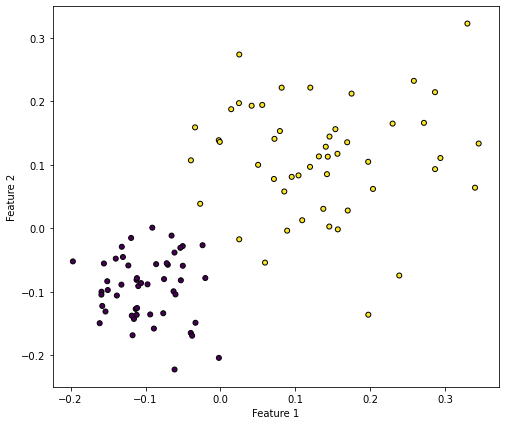

In [55]:
plt.figure(figsize=(8, 7))
plt.scatter(X1[:,0], X1[:,1], marker='o', c=y1, s=25, edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

In [56]:
#データフレームに変換
df_U=pd.DataFrame(X)
df_U_label=y
df_U_original=df_U.copy()
df_U_original

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,-0.076351,-0.134071,-0.087878,-0.185037,-0.062343,-0.176736,-0.099744,-0.106011,-0.140349,0.043591,...,-0.088375,-0.056619,-0.157411,0.005717,-0.049953,-0.102571,-0.092011,-0.135813,-0.097474,-0.107167
1,-0.052821,-0.082118,-0.104172,-0.066110,-0.072197,-0.088864,-0.176449,-0.048539,-0.158313,-0.150478,...,-0.024705,-0.129367,-0.031707,-0.038398,-0.077456,-0.132070,-0.168880,-0.051713,-0.164200,-0.163729
2,-0.023858,-0.026906,-0.098117,-0.112310,-0.133215,-0.082433,-0.124202,-0.175654,-0.138177,-0.087540,...,-0.189841,-0.079465,-0.114591,-0.063293,-0.106275,-0.154426,-0.089888,-0.117492,-0.171064,-0.158179
3,-0.150334,-0.097499,-0.061728,-0.101426,-0.160282,-0.119077,-0.071658,-0.046133,-0.147018,-0.085820,...,-0.150539,-0.105770,-0.042998,-0.083100,-0.076224,0.031952,-0.065445,-0.044438,-0.112884,-0.159798
4,-0.088773,-0.158173,-0.250796,-0.070302,-0.083430,-0.153641,-0.035528,-0.104276,-0.123831,-0.148186,...,-0.146253,-0.092842,-0.051224,-0.129988,-0.069645,-0.100930,-0.131078,-0.082669,-0.033125,-0.230250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.050252,0.099776,0.187314,0.306329,0.027590,0.058278,0.270901,-0.083864,0.101741,-0.000948,...,0.072935,0.055717,0.297850,-0.017530,0.253036,0.172501,0.071672,-0.038812,0.071440,0.238796
96,0.025108,0.273653,0.047710,0.202146,-0.044071,0.146659,0.127099,0.111849,-0.030840,0.087116,...,0.125690,0.146473,0.036532,0.174092,0.025322,-0.102064,0.087032,-0.004277,0.158998,0.081589
97,0.238604,-0.074595,0.200945,0.106342,0.218314,0.226176,0.088202,0.117364,0.043911,0.171940,...,-0.005991,0.122688,-0.120990,0.172930,0.067042,-0.029491,0.055627,-0.051100,0.150129,0.103331
98,0.142104,0.085075,0.087175,0.146076,0.161716,0.218585,0.219152,0.174781,0.186296,0.052160,...,0.188072,0.216084,0.166757,0.155498,0.058825,0.183132,0.110316,0.290463,0.006491,0.080826


## df_Vを生成

#### データを生成

In [62]:
n_samples_per_center=[50,50] #クラスターのそれぞれのデータ数
n_features=60
clust_number=2 #クラスターの数
random_state=13
#center_box=(-10,10)

generator = check_random_state(random_state)

#centers=generator.uniform(center_box[0],center_box[1],size=(clust_number,n_features)) #(クラスターの中心の範囲,size(クラスターの中心数，特徴量))
clust_center_1=np.full(n_features,-0.05)#(特徴量数，平均値)
clust_center_2=np.full(n_features,0.15)
centers=np.array([[clust_center_1],[clust_center_2]])#クラスターの中心の座標を指定
#centers=np.array([[-7.5,-7.5],[7.5,7.5],[9,-7.5]]) #クラスターの中心の座標を指定

#cluster_std=np.full(len(centers),1.0) #(クラスターの中心数,クラスター内標準偏差)
cluster_std=np.array([0.03,0.1]) #各クラスターの標準偏差

cum_sum_n_samples = np.cumsum(n_samples_per_center) #累積和の配列を作る

X = np.empty(shape=(sum(n_samples_per_center), n_features), dtype=np.float64)
y = np.empty(shape=(sum(n_samples_per_center),), dtype=int)

for i, (n, std) in enumerate(zip(n_samples_per_center, cluster_std)):
    start_idx = cum_sum_n_samples[i - 1] if i > 0 else 0
    end_idx = cum_sum_n_samples[i]
    X[start_idx:end_idx] = generator.normal(
        loc=centers[i], scale=std, size=(n, n_features)
    )
    y[start_idx:end_idx] = i
        
X2, y2 = shuffle(X, y, random_state=generator)

Text(0, 0.5, 'Feature 2')

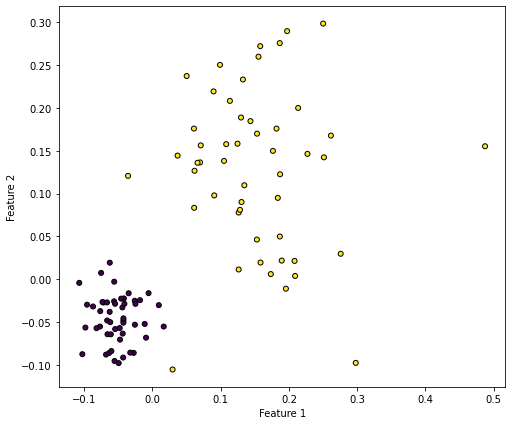

In [63]:
plt.figure(figsize=(8, 7))
plt.scatter(X2[:,0], X2[:,1], marker='o', c=y2, s=25, edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

In [64]:
df_V=pd.DataFrame(X)
df_V_label=y
df_V_original=df_V.copy()
df_V_original

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,-0.071372,-0.027387,-0.051335,-0.036446,-0.009647,-0.034030,-0.009494,-0.024164,-0.005639,-0.081361,...,-0.036405,-0.059980,-0.061534,-0.065910,-0.009491,0.010457,-0.051726,-0.033060,-0.039214,-0.065359
1,-0.065695,-0.064441,-0.107725,-0.072724,-0.036396,-0.022330,-0.056220,-0.061278,-0.030803,0.011611,...,-0.047574,-0.119595,-0.060234,-0.017305,-0.036484,-0.064829,-0.066397,-0.041239,-0.045374,-0.025481
2,-0.045687,-0.022845,-0.037980,-0.072938,-0.080510,-0.065810,-0.037740,-0.076034,-0.023246,-0.096172,...,-0.064939,-0.021846,-0.086693,-0.038942,-0.014629,-0.082283,-0.017172,-0.049862,-0.066056,-0.023949
3,-0.047810,-0.057202,-0.067335,-0.075250,-0.066602,-0.057245,-0.027133,-0.057576,-0.041251,-0.061690,...,-0.050553,-0.046770,-0.054674,-0.093904,-0.066005,-0.107971,-0.021801,-0.021482,-0.092337,-0.013858
4,-0.055349,-0.095696,-0.071962,-0.032745,-0.053097,-0.082370,-0.030324,-0.056740,-0.065410,-0.087718,...,-0.060477,-0.024685,-0.027743,-0.060560,-0.055715,-0.029832,-0.073991,-0.075341,-0.014832,-0.015528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.251309,0.142327,0.193413,0.428015,0.156174,0.145581,0.125714,0.218260,0.112039,0.022992,...,0.183139,0.262293,0.146911,0.188900,0.247010,0.230843,0.274660,0.120547,0.111310,0.119914
96,0.213559,0.200056,0.143630,0.070782,0.208794,0.065017,0.146421,-0.049527,0.037815,0.261803,...,0.165303,0.278411,0.124902,0.297009,0.170341,0.374405,0.304338,0.072034,0.094431,0.149515
97,0.153130,0.046235,0.106732,0.199641,0.136767,0.247230,0.122749,0.169331,0.243764,0.111269,...,0.136195,0.072702,0.046674,0.176439,-0.006753,0.163560,0.194539,0.167171,0.171189,0.100394
98,0.089677,0.219384,0.172662,0.093707,0.304736,0.206254,0.204018,0.125401,0.123763,0.089136,...,-0.014704,0.134095,0.012869,0.168681,0.263266,0.036956,0.053007,0.048213,0.092027,0.179044


#### ランダムに生成

Text(0, 0.5, 'Feature 2')

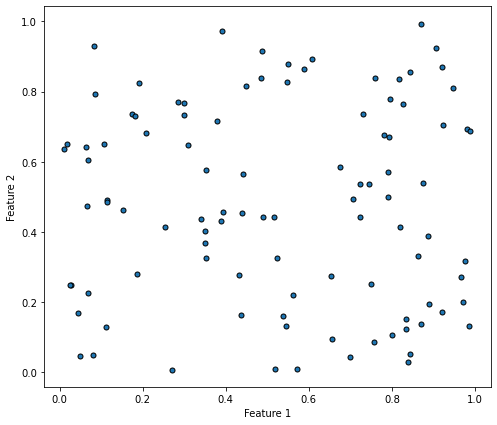

In [844]:
df_V = np.random.rand(100, 100)
plt.figure(figsize=(8, 7))
plt.scatter(df_V[:,0], df_V[:,1], marker='o', s=25, edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

In [794]:
df_V=pd.DataFrame(df_V)
df_V

,0,1,2,3,4,...,95,96,97,98,99
0,0.491529,0.629279,0.446803,0.075837,0.645685,...,0.065423,0.627562,0.199905,0.500108,0.538234
1,0.133422,0.956752,0.976849,0.048043,0.050593,...,0.114337,0.092249,0.600324,0.114698,0.383453
2,0.170785,0.279346,0.263780,0.783439,0.941532,...,0.760159,0.921075,0.801040,0.471537,0.670120
3,0.221805,0.792272,0.223590,0.246991,0.475233,...,0.636165,0.820037,0.280682,0.772423,0.980103
4,0.226672,0.234098,0.539817,0.728457,0.999579,...,0.036859,0.932482,0.424561,0.180354,0.289324
...,...,...,...,...,...,...,...,...,...,...,...
95,0.655043,0.955607,0.595142,0.058293,0.366592,...,0.205327,0.877630,0.639801,0.671680,0.833383
96,0.322139,0.481048,0.636871,0.171021,0.946025,...,0.358588,0.778025,0.887023,0.560682,0.882331
97,0.864776,0.588942,0.229078,0.950369,0.694705,...,0.384949,0.595585,0.030317,0.929509,0.055218
98,0.141045,0.173097,0.583344,0.217758,0.654407,...,0.600446,0.134353,0.944298,0.589222,0.961902


## df_Rを生成

### 掛け合わせる

In [87]:
ar_U=df_U.values
ar_VT=df_V.values.T
R=np.dot(ar_U,ar_VT)
R

array([[ 0.28356313,  0.36862623,  0.33911264, ..., -0.81796709,
        -1.11388572, -0.98975646],
       [ 0.29078113,  0.35863638,  0.32045002, ..., -0.86263521,
        -1.12430068, -0.91273199],
       [ 0.2712235 ,  0.36713351,  0.3594622 , ..., -0.89692788,
        -1.1161037 , -0.94630294],
       ...,
       [-0.24034992, -0.27754071, -0.29678938, ...,  0.77174258,
         0.96777875,  0.67491059],
       [-0.24160745, -0.34213918, -0.30983538, ...,  0.84842365,
         0.90510585,  0.87619806],
       [-0.36121294, -0.39298393, -0.39185167, ...,  1.19310018,
         1.11626036,  1.13389626]])

### 誤差を乗せる

In [85]:
n_samples=100 #クラスターのそれぞれのデータ数
n_features=100
#clust_number=2 #クラスターの数
random_state=12
#center_box=(-10,10)

generator = check_random_state(random_state)

#centers=generator.uniform(center_box[0],center_box[1],size=(clust_number,n_features)) #(クラスターの中心の範囲,size(クラスターの中心数，特徴量))
centers=np.full(n_features,0)#(特徴量数，平均値)
#clust_center_2=np.full(n_features,0.1)
#centers=np.array([[clust_center_1],[clust_center_2]])#クラスターの中心の座標を指定

#cluster_std=np.full(len(centers),1.0) #(クラスターの中心数,クラスター内標準偏差)
std=0.01 #各クラスターの標準偏差

#cum_sum_n_samples = np.cumsum(n_samples_per_center) #累積和の配列を作る

X = np.empty(shape=(n_samples, n_features), dtype=np.float64)
#y = np.empty(shape=(sum(n_samples_per_center),), dtype=int)


X[0:100] = generator.normal(
    loc=centers, scale=std, size=(n_samples, n_features))
        
X

array([[ 0.00472986, -0.00681426,  0.00242439, ..., -0.01446359,
        -0.00536481,  0.00197921],
       [-0.0136564 , -0.01194444,  0.00015935, ...,  0.00367393,
        -0.00959012, -0.01595297],
       [ 0.00507523, -0.00618371,  0.00790793, ...,  0.0034661 ,
         0.01337491, -0.02604996],
       ...,
       [-0.01714703,  0.00880748,  0.00918556, ..., -0.00290082,
        -0.00326166, -0.0083153 ],
       [ 0.00967321,  0.00570789, -0.00988034, ..., -0.00339962,
        -0.00550184, -0.01542173],
       [-0.02300419,  0.00685886, -0.01576602, ..., -0.00095875,
        -0.00086353,  0.00068703]])

### 足してデータフレームに

In [89]:
R=R+X
R

array([[ 0.28829299,  0.36181197,  0.34153704, ..., -0.83243069,
        -1.11925054, -0.98777726],
       [ 0.27712473,  0.34669194,  0.32060937, ..., -0.85896128,
        -1.1338908 , -0.92868496],
       [ 0.27629873,  0.3609498 ,  0.36737013, ..., -0.89346178,
        -1.10272878, -0.9723529 ],
       ...,
       [-0.25749696, -0.26873323, -0.28760382, ...,  0.76884176,
         0.96451708,  0.66659529],
       [-0.23193424, -0.33643128, -0.31971572, ...,  0.84502403,
         0.89960401,  0.86077633],
       [-0.38421713, -0.38612507, -0.4076177 , ...,  1.19214142,
         1.11539683,  1.13458328]])

In [91]:
df_R=pd.DataFrame(R)
df_R

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.288293,0.361812,0.341537,0.314795,0.309368,0.288056,0.288829,0.323797,0.365053,0.317688,...,-1.056293,-1.138227,-1.042374,-1.048218,-0.937529,-1.099088,-1.028302,-0.832431,-1.119251,-0.987777
1,0.277125,0.346692,0.320609,0.339465,0.302255,0.269981,0.309425,0.323392,0.407057,0.299997,...,-1.033461,-1.127691,-0.962410,-1.071790,-0.934918,-1.000999,-1.172566,-0.858961,-1.133891,-0.928685
2,0.276299,0.360950,0.367370,0.363304,0.307160,0.304716,0.279739,0.343322,0.397207,0.322615,...,-1.038130,-1.106629,-1.037286,-1.113933,-0.892230,-1.004845,-1.046050,-0.893462,-1.102729,-0.972353
3,0.323718,0.383206,0.337884,0.333765,0.314293,0.313810,0.344035,0.372219,0.397373,0.340070,...,-1.086016,-1.057809,-1.055718,-1.043693,-0.918540,-1.004827,-1.074261,-0.886120,-1.162971,-1.000775
4,0.301763,0.364801,0.359880,0.351895,0.321127,0.292450,0.365167,0.352564,0.391080,0.330566,...,-1.095892,-1.090475,-0.997312,-1.024633,-0.948441,-1.029958,-1.089848,-0.925289,-1.186584,-0.987792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.271346,-0.334632,-0.307682,-0.335412,-0.277272,-0.254411,-0.267837,-0.316406,-0.356516,-0.241781,...,0.910279,1.068384,0.960790,0.994715,0.873138,0.941754,1.098595,0.737144,1.122777,1.010262
96,-0.240514,-0.299544,-0.249252,-0.281968,-0.254807,-0.212838,-0.249648,-0.239446,-0.338195,-0.250383,...,0.754048,0.810634,0.873618,0.721682,0.805231,0.746486,0.844746,0.676958,0.865479,0.784413
97,-0.257497,-0.268733,-0.287604,-0.300434,-0.264763,-0.225371,-0.270654,-0.225948,-0.255103,-0.253692,...,0.800526,0.742767,0.687657,0.886978,0.831741,0.899364,0.899029,0.768842,0.964517,0.666595
98,-0.231934,-0.336431,-0.319716,-0.307857,-0.317436,-0.289252,-0.297076,-0.294808,-0.354496,-0.245425,...,0.875856,0.991902,0.871503,0.921171,0.824553,1.026227,0.972046,0.845024,0.899604,0.860776


### プロット

Text(0, 0.5, 'Feature 2')

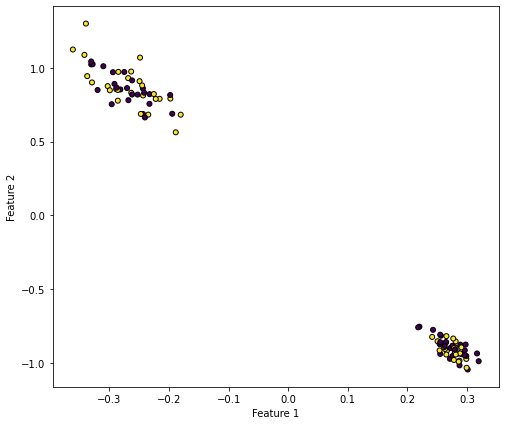

In [66]:
plt.figure(figsize=(8, 7))
plt.scatter(df_R[0],df_R[61], marker='o', c=y1, s=25, edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

Text(0, 0.5, 'Feature 2')

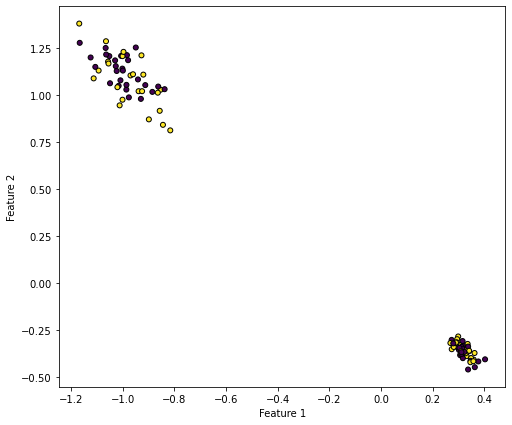

In [68]:
plt.figure(figsize=(8, 7))
plt.scatter(df_R.iloc[1],df_R.iloc[55], marker='o', c=y2, s=25, edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

In [69]:
df_R.to_csv("/Users/kiyopippi/Desktop/卒業研究/データ/df_R_original.csv")

## 欠損を生成

In [70]:
def make_null(df,index,col_name): #データフレーム,発生させた乱数,列名
  df1 = df.drop(index) #欠損しないindexを集めたデータ
  df2 = df.iloc[index, :] #欠損するindexを集めたデータ
  df_c = df2[col_name] #欠損するindexを集めたデータの列名を指定
  df2[col_name] = np.nan #nanに置き換え
  result_df = pd.concat([df1,df2]).sort_index() #df1とdf2をくっつける
  return result_df, df_c #くっつけたデータと欠損した列名を返す

In [71]:
df_R_missing=pd.DataFrame()
np.random.seed(11) #乱数のシード値
for i in list(range(100)):#range(データフレームの列数)
    rand_mcar = np.sort(np.random.choice(df_R.index,70,replace=False)) #df1のインデックス番号からx個重複を許さず乱数発生
    dfR_result , mcar_correct = make_null(df_R, rand_mcar,i)
    dfR_result=list(dfR_result[i])
    df_R_missing.insert(i,i,dfR_result)

<ipython-input-70-7a8f389ec19c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[col_name] = np.nan #nanに置き換え


In [72]:
df_R_missing

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,NaN,NaN,0.339113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.940253,NaN,-1.037022,NaN,-1.113886,NaN
1,0.290781,NaN,NaN,NaN,NaN,NaN,0.320452,NaN,0.376640,0.306258,...,NaN,-1.106149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,0.371649,NaN,0.317104,NaN,NaN,NaN,0.330578,...,-1.028879,NaN,-1.047041,NaN,NaN,NaN,-1.039835,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,0.304524,NaN,NaN,0.359175,NaN,0.338208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.892947,-1.157317,-0.999457
4,0.298754,0.356124,NaN,0.355946,NaN,NaN,NaN,NaN,0.376533,NaN,...,NaN,NaN,NaN,NaN,-0.962338,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,NaN,-0.342369,NaN,-0.323081,-0.271755,NaN,-0.256513,-0.307914,NaN,-0.256826,...,0.905959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.127088,1.020292
96,NaN,NaN,-0.248004,NaN,NaN,-0.218005,NaN,NaN,-0.329444,NaN,...,NaN,NaN,0.875337,NaN,0.809621,NaN,NaN,0.674103,NaN,NaN
97,NaN,-0.277541,NaN,-0.305271,NaN,-0.232125,-0.264721,NaN,-0.264763,-0.251272,...,0.796291,0.744344,NaN,NaN,0.844530,0.907201,0.906021,NaN,NaN,NaN
98,NaN,NaN,NaN,-0.306325,-0.295148,-0.286701,NaN,NaN,NaN,-0.261882,...,NaN,NaN,NaN,0.920072,NaN,NaN,NaN,0.848424,NaN,NaN


In [73]:
df_R_missing.to_csv("/Users/kiyopippi/Desktop/卒業研究/データ/df_R__missing_original.csv")

# 分析

## 1回目のLFA

In [82]:
df_R_missing=df_R_missing.fillna(0) #欠損値を０で穴埋め
ar_R_missing=df_R_missing.values #データフレームをarray型に変換
parameters = [
    {"alpha": [0.1, 0.01, 0.001],
     "lamda": [0.001, 0.0001]}
]
#mf = MatrixFactorization(ar_R_missing,k=60) #array型のデータ,行数,列数,LFA次元,
mf = MatrixFactorization()
clf=GridSearchCV(mf,parameters)
U,VT=clf.fit(ar_R_missing)
df_U1=pd.DataFrame(U)
df_V1=pd.DataFrame(VT.T)

TypeError: __init__() missing 3 required positional arguments: 'R', 'alpha', and 'lamda'

In [659]:
df_U1

,0,1,2,3,4,...,55,56,57,58,59
0,-0.776194,0.437198,-0.103642,0.019767,0.634932,...,-0.154125,-0.115832,-0.274640,0.478683,0.204875
1,-0.748278,0.090051,0.653877,0.444950,0.499740,...,-0.162979,-0.035921,-0.254125,-0.179457,-0.593319
2,-0.542917,0.299612,0.057694,1.027113,0.425275,...,-0.512248,-0.120949,0.117253,0.054528,0.091408
3,-0.298467,0.000543,0.716676,0.383240,0.187477,...,-0.396539,-0.257223,-0.369554,0.306784,0.059522
4,-0.463366,0.205048,0.688357,0.217038,0.566007,...,-0.042161,0.447632,-0.285111,0.422990,-0.551051
...,...,...,...,...,...,...,...,...,...,...,...
95,1.955974,-0.083020,0.033183,-0.152089,0.366250,...,0.791632,0.431426,1.423838,0.140888,0.461703
96,0.879364,-1.048718,-0.643509,-0.322638,-0.586922,...,1.568625,0.393459,1.392581,0.191263,1.598570
97,0.691868,-0.350752,-0.780082,-0.059912,0.147426,...,0.163248,-0.332458,-0.030262,-0.495850,1.055778
98,1.334958,0.091285,0.082992,0.204670,-0.240532,...,0.611305,0.052040,1.473372,0.592867,0.542448


In [758]:
df_V1

,0,1,2,3,4,...,56,57,58,59,clust_label
0,-0.613753,0.072744,0.810574,0.049188,0.691440,...,0.006942,-0.723799,-0.022296,-0.523111,0
1,-0.947459,-0.039099,0.276624,0.242442,0.159543,...,0.374063,-0.231210,0.063485,-0.401356,0
2,-0.785065,0.103358,0.297365,0.229406,0.488954,...,-0.005365,-0.571408,0.058975,-0.606770,0
3,-0.432110,-0.151818,0.314840,0.042047,0.112829,...,-0.216942,-0.420093,0.510422,-0.690833,0
4,-0.494108,-0.153752,0.666719,0.228438,0.276342,...,-0.031885,-0.362749,0.457788,-0.139153,0
...,...,...,...,...,...,...,...,...,...,...,...
95,1.549235,0.206286,0.257430,-0.869653,0.433207,...,0.169263,0.957500,0.323821,1.381395,1
96,0.360736,0.329806,-0.030740,-0.044440,0.097199,...,0.933200,0.134247,-0.348241,-0.260691,1
97,1.834279,0.175760,-0.234187,0.275187,0.104996,...,0.755391,0.472070,0.171996,0.624459,1
98,0.441643,0.131161,-0.241934,-0.252010,-0.882369,...,0.212997,-0.327472,0.540880,0.141378,1


In [662]:
df_U1.to_csv("/Users/kiyopippi/Desktop/卒業研究/データ/df_U1.csv")

In [663]:
df_V1.to_csv("/Users/kiyopippi/Desktop/卒業研究/データ/df_V1.csv")

## 1回目時点での精度

In [664]:
ar_U1=df_U1.values
ar_V1=df_V1.values
R1_hat=pd.DataFrame(np.dot(ar_U1,ar_V1.T))
R1_hat

,0,1,2,3,4,...,95,96,97,98,99
0,7.242612,8.119434,7.615018,7.248915,6.334246,...,-9.678718,-5.247602,-7.073432,-10.043292,-3.551545
1,8.017008,7.183819,6.404348,6.721097,6.930881,...,-9.612368,-4.492227,-8.907176,-8.955768,-1.573659
2,7.538474,9.139425,7.950020,8.051443,7.765564,...,-9.273221,-4.085088,-8.722208,-8.613325,-4.547890
3,7.531514,7.595085,7.954641,7.280553,7.179712,...,-7.700490,-4.179731,-8.955260,-8.704484,-3.395095
4,7.806798,9.167207,6.955403,7.833596,7.550203,...,-10.228818,-3.029995,-7.372088,-9.837056,-1.704836
...,...,...,...,...,...,...,...,...,...,...,...
95,-6.579499,-9.237934,-9.300372,-7.858871,-7.492844,...,13.119819,4.847022,10.618578,5.772915,7.366789
96,-9.348512,-8.777247,-10.637869,-8.850583,-7.773751,...,9.837843,3.169099,11.391214,7.716927,5.416124
97,-6.300896,-7.998272,-7.063687,-6.821501,-6.474297,...,4.147452,-0.745659,7.454565,5.189146,1.618398
98,-4.834509,-5.780780,-5.763744,-6.298468,-5.414670,...,6.625087,2.213472,9.389324,3.839519,4.473442


In [665]:
#元の行列の値とR_hatの誤差を調べる
def RMSE0(ar_original,ar_R_hat):#元の欠損する前の行列(array型),欠損した行列,潜在因子行列をかけた行列
    total=0
    x=ar_original.shape[0]
    y=ar_original.shape[1]
    count=x*y
    X=list(range(ar_original.shape[0]))
    Y=list(range(ar_original.shape[1]))
    for i in X:
        for j in Y:    
            total+=(ar_original[i,j]-ar_R_hat[i,j])**2
    score=np.sqrt(total/count)
    return score,count

In [666]:
ar_R=df_R.values
ar_R1_hat=R1_hat.values
score,count=RMSE0(ar_R,ar_R1_hat)
print(score)
print(count)

1.637954981625289
10000


## RでDPクラスタリング

## 提案手法はcolabで実装

## DPクラスタリングの結果をono-hotエンコーディングする

In [667]:
df_U1_re=pd.read_csv("/Users/kiyopippi/Desktop/卒業研究/データ/df_U1_clustering_result.csv")
df_U1_re

,Unnamed: 0,X0,X1,X2,X3,...,X56,X57,X58,X59,clust_label
0,1,-0.776194,0.437198,-0.103642,0.019767,...,-0.115832,-0.274640,0.478683,0.204875,0
1,2,-0.748278,0.090051,0.653877,0.444950,...,-0.035921,-0.254125,-0.179457,-0.593319,0
2,3,-0.542917,0.299612,0.057694,1.027113,...,-0.120949,0.117253,0.054528,0.091408,0
3,4,-0.298467,0.000543,0.716676,0.383240,...,-0.257223,-0.369554,0.306784,0.059522,0
4,5,-0.463366,0.205048,0.688357,0.217038,...,0.447632,-0.285111,0.422990,-0.551051,0
...,...,...,...,...,...,...,...,...,...,...,...
95,96,1.955974,-0.083020,0.033183,-0.152089,...,0.431426,1.423838,0.140888,0.461703,1
96,97,0.879364,-1.048718,-0.643509,-0.322638,...,0.393459,1.392581,0.191263,1.598570,1
97,98,0.691868,-0.350752,-0.780082,-0.059912,...,-0.332458,-0.030262,-0.495850,1.055778,1
98,99,1.334958,0.091285,0.082992,0.204670,...,0.052040,1.473372,0.592867,0.542448,1


In [698]:
label_U1=df_U1_re["clust_label"]
label_U1_onehot=np_utils.to_categorical(label_U1)
#label_U1_onehot=np.tile(label_U1_onehot,50)
label_U1_onehot

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [670]:
df_V1_re=pd.read_csv("/Users/kiyopippi/Desktop/卒業研究/データ/df_V1_clustering_result.csv")
df_V1_re

,Unnamed: 0,X0,X1,X2,X3,...,X56,X57,X58,X59,clust_label
0,1,-0.613753,0.072744,0.810574,0.049188,...,0.006942,-0.723799,-0.022296,-0.523111,0
1,2,-0.947459,-0.039099,0.276624,0.242442,...,0.374063,-0.231210,0.063485,-0.401356,0
2,3,-0.785065,0.103358,0.297365,0.229406,...,-0.005365,-0.571408,0.058975,-0.606770,0
3,4,-0.432110,-0.151818,0.314840,0.042047,...,-0.216942,-0.420093,0.510422,-0.690833,0
4,5,-0.494108,-0.153752,0.666719,0.228438,...,-0.031885,-0.362749,0.457788,-0.139153,0
...,...,...,...,...,...,...,...,...,...,...,...
95,96,1.549235,0.206286,0.257430,-0.869653,...,0.169263,0.957500,0.323821,1.381395,1
96,97,0.360736,0.329806,-0.030740,-0.044440,...,0.933200,0.134247,-0.348241,-0.260691,1
97,98,1.834279,0.175760,-0.234187,0.275187,...,0.755391,0.472070,0.171996,0.624459,1
98,99,0.441643,0.131161,-0.241934,-0.252010,...,0.212997,-0.327472,0.540880,0.141378,1


In [699]:
label_V1=df_V1_re["clust_label"]
label_V1_onehot=np_utils.to_categorical(label_V1)
label_V1_onehot=label_V1_onehot.T
#label_V1_onehot=np.tile(label_V1_onehot,(50,1))
label_V1_onehot

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.]], dtype=float32)

## ユーザーのクラスター内標準偏差を計算

### クラスが0のデータのクラスター内標準偏差

In [681]:
df_U1["clust_label"]=df_U1_re["clust_label"]
df_U1.to_csv("/Users/kiyopippi/Desktop/卒業研究/データ/df_U1_DCALF-A.csv")
df_U1_0=df_U1[df_U1["clust_label"]==0]
df_U1_0=df_U1_0.iloc[:,:60]
df_U1_0_std=df_U1_0.describe().loc['std'].mean()
df_U1_0_std

0.26340757444235824

In [682]:
df_U1_0

,0,1,2,3,4,...,55,56,57,58,59
0,-0.776194,0.437198,-0.103642,0.019767,0.634932,...,-0.154125,-0.115832,-0.274640,0.478683,0.204875
1,-0.748278,0.090051,0.653877,0.444950,0.499740,...,-0.162979,-0.035921,-0.254125,-0.179457,-0.593319
2,-0.542917,0.299612,0.057694,1.027113,0.425275,...,-0.512248,-0.120949,0.117253,0.054528,0.091408
3,-0.298467,0.000543,0.716676,0.383240,0.187477,...,-0.396539,-0.257223,-0.369554,0.306784,0.059522
4,-0.463366,0.205048,0.688357,0.217038,0.566007,...,-0.042161,0.447632,-0.285111,0.422990,-0.551051
...,...,...,...,...,...,...,...,...,...,...,...
45,-0.280529,0.181858,0.071449,0.685698,1.315355,...,-0.108963,-0.357363,-0.632909,-0.245817,-0.143709
46,-0.818033,0.019658,0.105755,0.682294,-0.143402,...,-0.473406,0.015697,-0.255666,-0.295564,-0.034832
47,-0.645705,0.068352,0.194598,0.260427,0.256768,...,-0.786079,0.314091,-0.143127,0.278099,-0.605803
48,-0.988645,0.273853,0.608084,0.589058,0.529567,...,-0.352396,0.021292,-0.230480,0.380908,-0.148832


### クラスが1のデータのクラスター内標準偏差

In [683]:
df_U1["clust_label"]=df_U1_re["clust_label"]
df_U1_1=df_U1[df_U1["clust_label"]==1]
df_U1_1=df_U1_1.iloc[:,:60]
df_U1_1_std=df_U1_1.describe().loc['std'].mean()
df_U1_1_std

0.4117540102127217

### リストに格納

In [684]:
user_clust_std=list([df_U1_0_std,df_U1_1_std])
user_clust_std

[0.26340757444235824, 0.4117540102127217]

## サービスのクラスター内標準偏差を計算

### クラスが0のデータのクラスター内標準偏差

In [695]:
df_V1["clust_label"]=df_V1_re["clust_label"]
df_V1.to_csv("/Users/kiyopippi/Desktop/卒業研究/データ/df_V1_DCALF-A.csv")
df_V1_0=df_V1[df_V1["clust_label"]==0]
df_V1_0=df_V1_0.iloc[:,:60]
df_V1_0_std=df_V1_0.describe().loc['std'].mean()
df_V1_0_std

0.2696876944364737

### クラスが1のデータのクラスター内標準偏差

In [696]:
df_V1["clust_label"]=df_V1_re["clust_label"]
df_V1_1=df_V1[df_V1["clust_label"]==1]
df_V1_1=df_V1_1.iloc[:,:60]
df_V1_1_std=df_V1_1.describe().loc['std'].mean()
df_V1_1_std

0.433730709346863

### リストに格納


In [687]:
service_clust_std=list([df_V1_0_std,df_V1_1_std])
service_clust_std

[0.2696876944364737, 0.433730709346863]

## 2回目のLFA

#### 重み変えない+ユーザのみクラスター

In [413]:
C=label_U1_onehot
df_R_missing=df_R_missing.fillna(0) #欠損値を０で穴埋め
ar_R_missing=df_R_missing.values #データフレームをarray型に変換
mf = MatrixFactorization_1_1(ar_R_missing,C,k=60)
U,VT,S=mf.fit()
df_U2=pd.DataFrame(U)
df_V2=pd.DataFrame(VT)
df_S=pd.DataFrame(S)

In [414]:
ar_U2=df_U2.values
ar_V2=df_V2.values
R2_hat=pd.DataFrame(np.dot(ar_U2,ar_V2))
R2_hat

,0,1,2,3,4,...,95,96,97,98,99
0,-14.692683,-13.539463,-15.572225,-13.722075,-15.508433,...,-16.034260,-16.462524,-16.103778,-20.408629,-15.453587
1,-16.818712,-15.841313,-14.982156,-13.012394,-15.830160,...,-15.963930,-16.554935,-16.371202,-20.839706,-15.757262
2,-15.450784,-15.469156,-14.667788,-14.462866,-15.526465,...,-16.044704,-16.721829,-16.783376,-20.540367,-15.667000
3,-14.902487,-14.284886,-13.185726,-12.800385,-16.169453,...,-15.681756,-15.687509,-15.861346,-19.073019,-14.724682
4,-16.258434,-16.877544,-14.438515,-13.847516,-15.921124,...,-15.327359,-16.225810,-15.522840,-19.468666,-14.384923
...,...,...,...,...,...,...,...,...,...,...,...
95,14.379344,15.582511,14.186328,17.167781,16.378603,...,16.749729,15.699800,14.710722,21.009145,12.131640
96,17.247017,18.984742,16.774913,17.327582,18.680786,...,18.702389,18.330952,17.867770,23.797754,16.482714
97,12.822143,14.632304,12.259157,12.222605,14.085973,...,14.587556,13.341292,13.153754,17.552094,12.010617
98,10.063853,10.410975,9.694236,10.412029,12.181831,...,11.970369,12.078608,11.007558,15.165318,10.777778


In [415]:
ar_R=df_R.values
ar_R2_hat=R2_hat.values
score,count=RMSE0(ar_R,ar_R2_hat)
print(score)
print(count)

1.1617292912373638
10000


#### 重み変えない＋両方クラスター


In [762]:
C=label_U1_onehot
D=label_V1_onehot
df_R_missing=df_R_missing.fillna(0) #欠損値を０で穴埋め
ar_R_missing=df_R_missing.values #データフレームをarray型に変換
mf = MatrixFactorization_1(ar_R_missing,C,D,k=60)
U,VT,S,T=mf.fit()
df_U2=pd.DataFrame(U)
df_V2=pd.DataFrame(VT)
df_S=pd.DataFrame(S)
df_T=pd.DataFrame(T)

100%|██████████| 200/200 [15:16<00:00,  4.58s/it]


In [521]:
ar_U2=df_U2.values
ar_V2=df_V2.values
R2_hat=pd.DataFrame(np.dot(ar_U2,ar_V2))
R2_hat

,0,1,2,3,4,...,95,96,97,98,99
0,13.209313,14.350829,15.712956,12.828501,13.037978,...,-15.425024,-11.748479,-15.112462,-18.461019,-10.571874
1,16.174675,16.311019,15.432872,15.163114,14.297083,...,-17.448137,-9.246392,-17.038566,-17.546599,-8.396742
2,15.466702,16.601617,14.372065,15.930892,14.604075,...,-14.795973,-10.626841,-18.283454,-17.874238,-10.791228
3,14.649395,15.186533,15.632885,14.281221,14.702421,...,-16.110208,-8.074952,-16.970117,-16.642615,-9.184879
4,15.671044,16.994369,14.531712,15.633889,14.106396,...,-16.326773,-8.178251,-16.216639,-16.074504,-7.456076
...,...,...,...,...,...,...,...,...,...,...,...
95,-16.037189,-18.267898,-14.945266,-16.871021,-16.528753,...,15.531421,8.088826,19.243607,11.666255,13.788751
96,-17.608155,-18.422054,-23.508432,-17.760221,-17.515619,...,14.891263,8.449625,18.302277,16.495377,6.066502
97,-14.163821,-15.202073,-12.932579,-14.078477,-12.666468,...,9.785029,2.980921,19.045565,13.976676,9.403152
98,-11.587867,-12.262551,-12.254591,-12.335067,-11.415771,...,12.937690,6.297240,16.767976,10.952931,5.175285


### 評価(重みを変えない)

In [522]:
ar_R=df_R.values
ar_R2_hat=R2_hat.values
score,count=RMSE0(ar_R,ar_R2_hat)
print(score)
print(count)

2.3575900686008024
10000


## 2回目のLFA(重みを変える)

#### 重み変える+ユーザのみクラスター

In [409]:
C=label_U1_onehot
df_R_missing=df_R_missing.fillna(0) #欠損値を０で穴埋め
ar_R_missing=df_R_missing.values #データフレームをarray型に変換
mf = MatrixFactorization_2_1(ar_R_missing,C,label_U1,user_clust_std,k=60)
U,VT,S,=mf.fit()
df_U2=pd.DataFrame(U)
df_V2=pd.DataFrame(VT)
df_S=pd.DataFrame(S)

In [410]:
ar_U2=df_U2.values
ar_V2=df_V2.values
R2_hat=pd.DataFrame(np.dot(ar_U2,ar_V2))
R2_hat

,0,1,2,3,4,...,95,96,97,98,99
0,-14.569186,-14.025948,-15.585619,-13.749671,-15.161700,...,-15.974013,-16.483946,-16.692456,-20.406023,-15.605347
1,-16.804734,-15.928917,-15.928938,-13.558390,-15.531444,...,-15.699348,-16.533076,-16.272359,-20.814015,-15.222309
2,-15.463439,-15.676906,-15.560163,-14.460122,-15.784122,...,-15.755964,-16.724485,-15.662397,-20.180644,-15.037113
3,-15.283372,-15.217728,-14.441701,-12.882614,-16.149807,...,-15.188465,-16.291367,-15.866287,-19.054821,-14.733751
4,-16.271508,-16.838518,-14.991156,-13.847290,-15.905756,...,-15.646907,-15.837909,-15.310450,-19.550649,-14.395735
...,...,...,...,...,...,...,...,...,...,...,...
95,14.464983,15.563465,15.088514,17.175301,16.368161,...,15.783564,15.778407,14.833232,21.017125,12.124198
96,18.104513,20.121484,16.771525,16.312854,19.058105,...,18.901537,19.023149,17.861908,22.979491,15.861266
97,13.723754,14.641874,12.275423,12.216444,14.673727,...,14.586429,13.331893,12.625985,18.184415,13.134001
98,10.504441,11.831333,11.450983,10.397956,12.184886,...,12.830101,11.626317,11.011851,14.755041,10.777583


In [411]:
ar_R=df_R.values
ar_R2_hat=R2_hat.values
score,count=RMSE0(ar_R,ar_R2_hat)
print(score)
print(count)

1.138861620435225
10000


#### 重み変える+両方クラスター

In [720]:
C=label_U1_onehot
D=label_V1_onehot
df_R_missing=df_R_missing.fillna(0) #欠損値を０で穴埋め
ar_R_missing=df_R_missing.values #データフレームをarray型に変換
mf = MatrixFactorization_2(ar_R_missing,C,D,label_U1,label_V1,user_clust_std,service_clust_std,k=60)
U,VT,S,T=mf.fit()
df_U2=pd.DataFrame(U)
df_V2=pd.DataFrame(VT)
df_S=pd.DataFrame(S)
df_T=pd.DataFrame(T)

100%|██████████| 200/200 [15:51<00:00,  4.76s/it]


In [721]:
ar_U2=df_U2.values
ar_V2=df_V2.values
R2_hat=pd.DataFrame(np.dot(ar_U2,ar_V2))
R2_hat

,0,1,2,3,4,...,95,96,97,98,99
0,7.384689,8.531716,7.597865,7.239293,7.354974,...,-7.532574,-5.230928,-7.228852,-10.012860,-1.300274
1,7.990167,9.004291,7.474818,8.015800,7.289856,...,-11.156326,-4.250824,-8.982704,-8.708783,-2.841577
2,8.795168,9.583510,7.917063,8.026133,7.629556,...,-9.347468,-4.077613,-5.603481,-8.259534,-2.013390
3,7.405235,8.691485,6.591881,7.671428,7.139384,...,-10.257076,-2.131613,-8.924493,-8.719662,-3.349510
4,7.813507,9.134889,6.857807,7.850143,7.781062,...,-8.648037,-3.036859,-6.562141,-7.832352,-2.581929
...,...,...,...,...,...,...,...,...,...,...,...
95,-7.209102,-9.195309,-7.342867,-7.835790,-7.464158,...,10.442867,4.327248,9.758855,5.811724,7.297501
96,-10.325288,-8.584771,-10.612208,-8.706358,-7.245677,...,11.434750,4.293112,11.399392,5.116097,5.953013
97,-6.632690,-7.993579,-6.230598,-6.830718,-6.583414,...,4.148905,-0.673673,7.949053,5.780250,1.646966
98,-7.541918,-6.277103,-5.621060,-6.272005,-5.399893,...,7.075459,3.971039,9.369282,4.790458,2.342849


### 評価(重みを変える)

In [722]:
ar_R=df_R.values
ar_R2_hat=R2_hat.values
score,count=RMSE0(ar_R,ar_R2_hat)
print(score)
print(count)

1.6460680852466396
10000


Text(0, 0.5, 'Feature 2')

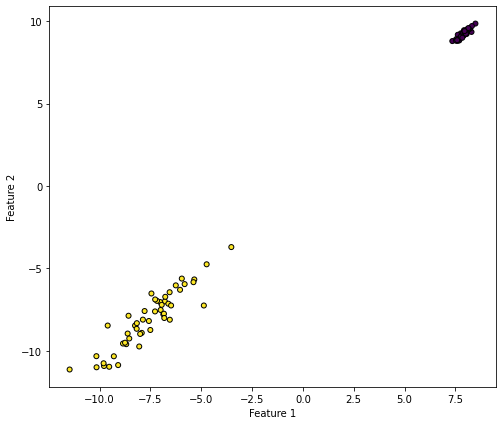

In [716]:
plt.figure(figsize=(8, 7))
plt.scatter(df_R[0], df_R[1], marker='o', c=df_U1_re["clust_label"], s=25, edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

Text(0, 0.5, 'Feature 2')

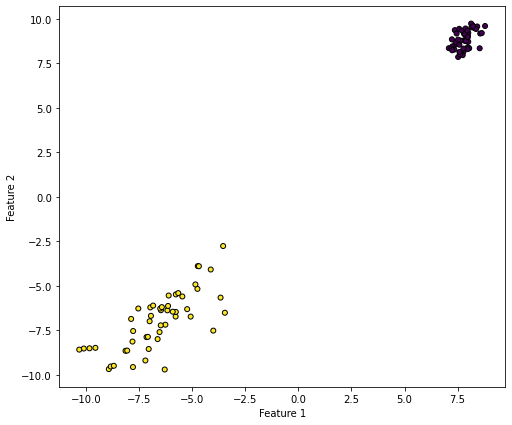

In [723]:
plt.figure(figsize=(8, 7))
plt.scatter(R2_hat[0], R2_hat[1], marker='o', c=df_U1_re["clust_label"], s=25, edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

Text(0, 0.5, 'Feature 2')

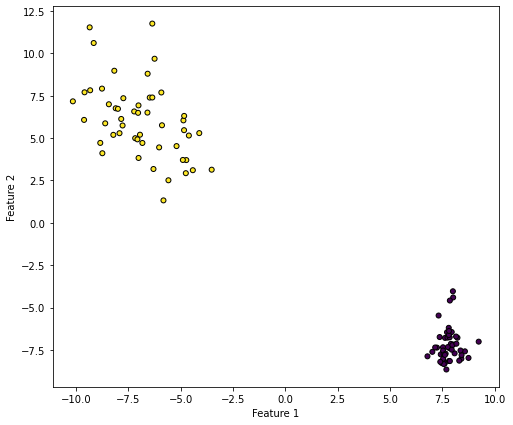

In [861]:
plt.figure(figsize=(8, 7))
plt.scatter(R1_hat[0], R1_hat[61], marker='o', c=df_U1_re["clust_label"], s=25, edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")